In [1]:
import numpy as np
import tensorflow as tf
import keras
import os
import re
import random
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPool2D, Dropout, Input, LeakyReLU
from keras.preprocessing.image import img_to_array
from keras import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
import os, warnings
import json
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from keras import backend
from keras import utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input


In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Define the root directory
ROOT_DIR = '/content/drive/My Drive/'

In [4]:
# Constants :
batch_size = 64
img_path = '/content/drive/MyDrive/kaggle_datasets/'

In [5]:
def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  #return img, img
  return img

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.batch(batch_size, drop_remainder=True) # fix my bug?
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = tf.data.Dataset.list_files(img_path , shuffle=False)
val_ds = tf.data.Dataset.list_files(img_path , shuffle=False)
test_ds = tf.data.Dataset.list_files(img_path , shuffle=False)

# Use Dataset.map to create a dataset of image, label pairs:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [6]:
print(train_ds)
print(val_ds)

<_PrefetchDataset element_spec=TensorSpec(shape=(64, None, None, 3), dtype=tf.uint8, name=None)>
<_PrefetchDataset element_spec=TensorSpec(shape=(64, None, None, 3), dtype=tf.uint8, name=None)>


In [7]:
cel_dir="/content/drive/MyDrive/kaggle_datasets/cropped_sketch"
train_ds=tf.keras.utils.image_dataset_from_directory(
    cel_dir,
    labels=None,
    label_mode='int',
    class_names=None,
    color_mode="rgb",
    batch_size=128,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1194 files belonging to 1 classes.


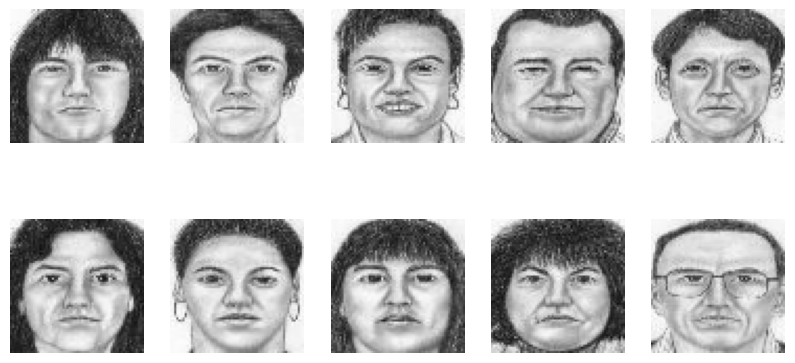

In [8]:
plt.figure(figsize=(10, 5))
#for image_batch, label_batch in train_ds.take(1):
for image_batch in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show();

In [9]:
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import Rescaling

def create_preprocesser():

    inputs = keras.Input(shape=(64,64,3))

    preprocessed = Rescaling(1./255)(inputs)

    preprocesser = Model(inputs,preprocessed, name='preprocesser')

    return preprocesser

In [10]:
from tensorflow.keras import layers

def create_encoder():

    inputs = keras.Input(shape=(64,64,3))

    # 32x4x4 conv, stride 2 + BN + LeakyReLU
    x = layers.Conv2D(32,(4, 4), strides=2, padding='same', activation=None)(inputs)
    x = layers.BatchNormalization(axis=-1)(x) # axis=-1 as data format is 'channels_last' and we want to normalize each channel
    x = layers.LeakyReLU(alpha=0.3)(x)

    #64x4x4 conv, stride 2 + BN + LeakyReLU
    x = layers.Conv2D(64,(4, 4), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    #128x4x4 conv, stride 2 + BN + LeakyReLU
    x = layers.Conv2D(128,(4, 4), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    #256x4x4 conv, stride 2 + BN + LeakyReLU
    x = layers.Conv2D(256,(4, 4), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # flatten the output
    x = layers.Flatten(data_format='channels_last')(x)

    # distribution parameters
    z_mean = layers.Dense(units=100, activation=None)(x)
    z_log_sigma = layers.Dense(units=100, activation=None)(x)

    # use these parameters to sample new similar points from the latent space:
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = backend.random_normal(shape=(1, 100), mean=0., stddev=0.1)
        #epsilon = backend.random_normal(shape=(1, 100), mean=0., stddev=1.)
        return z_mean + backend.exp(z_log_sigma / 2) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Create encoder
    encoder = Model(inputs,[z_mean, z_log_sigma, z], name='encoder')
    #encoder.summary()

    return encoder

In [11]:
def create_decoder():

    inputs = keras.Input(shape=(100))

    x = layers.Dense(units=4096, activation='relu')(inputs)
    x = layers.Reshape((4,4,256))(x)

    # upsample + conv128x3x3 + BN + LeakyReLU
    x = layers.UpSampling2D((2,2), data_format='channels_last', interpolation='nearest')(x)
    x = layers.Conv2D(128,(3, 3), padding='same', strides=(1,1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # upsample + conv64x3x3 + BN + LeakyReLU
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64,(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # upsample + conv32x3x3 + BN + LeakyReLU
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32,(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # upsample + conv128x3x3
    x = layers.UpSampling2D((2,2))(x)
    decoded = layers.Conv2D(3,(3, 3), padding='same')(x)

    decoder = Model(inputs, decoded, name='decoder')
    return decoder

In [12]:
class PVAE(keras.Model):

    def __init__(self, preprocesser, encoder, decoder, alpha, beta, **kwargs):
        super(PVAE, self).__init__(**kwargs)
        self.preprocesser = preprocesser
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.loss_wo_weight_tracker = keras.metrics.Mean(name="loss_wo_weight")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.alpha = alpha
        self.beta = beta

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [
            self.loss_tracker,
            self.loss_wo_weight_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def forward(self, data):
        # Forward pass
        preprocessed = self.preprocesser(data)
        z_mean, z_log_sigma, z = self.encoder(preprocessed)
        reconstruction = self.decoder(z)
        return z_mean, z_log_sigma,reconstruction

    def compute_loss(self, data, z_mean, z_log_sigma, reconstruction):
        reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        loss_wo_weight = reconstruction_loss + kl_loss
        loss = self.alpha * reconstruction_loss + self.beta * kl_loss
        return reconstruction_loss, kl_loss, loss, loss_wo_weight

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_sigma, reconstruction = self.forward(data)
            # Compute the loss value
            reconstruction_loss, kl_loss, loss, loss_wo_weight = self.compute_loss(data, z_mean, z_log_sigma, reconstruction)
        # Compute gradients
        grads = tape.gradient(loss, self.trainable_variables)
        # Update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        # Update metrics (metrics = losses in our case)
        self.loss_tracker.update_state(loss)
        self.loss_wo_weight_tracker.update_state(loss_wo_weight)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Return metrics
        return {
            "loss": self.loss_tracker.result(),
            "loss_wo_weight": self.loss_wo_weight_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, data):
        # Forward pass
        z_mean, z_log_sigma, reconstruction = self.forward(data)
        # Compute the loss value
        reconstruction_loss, kl_loss, loss, loss_wo_weight = self.compute_loss(data, z_mean, z_log_sigma, reconstruction)
        # Update metrics (metrics = losses in our case)
        self.loss_tracker.update_state(loss)
        self.loss_wo_weight_tracker.update_state(loss_wo_weight)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        # Return metrics
        return {
            "loss": self.loss_tracker.result(),
            "loss_wo_weight": self.loss_wo_weight_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction":reconstruction,
        }

In [28]:
# Option 2: Remove the line that tries to plot the val_reconstruction_loss
def display_history(history):
    fig=plt.figure(figsize=(20,5))

    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history['reconstruction_loss'])
    plt.title('reconstruction_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')

    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history['kl_loss'])
    plt.title('kl_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')

    plt.show()

In [14]:
alpha = 1.8
beta = 10
lr = 0.0015

ppreprocesser = create_preprocesser()
pencoder = create_encoder()
pdecoder = create_decoder()
pvae = PVAE(ppreprocesser, pencoder, pdecoder, alpha, beta)
pvae.compile(optimizer=keras.optimizers.Adam(lr))

callbacks = [
    ReduceLROnPlateau(monitor='val_loss_wo_weight', factor=0.2, patience=2, verbose=1, mode='min'),
    ModelCheckpoint(filepath='./pvae/', monitor="val_loss_wo_weight", verbose=1, save_best_only=True)
]
history_pvae = pvae.fit(train_ds, epochs=100, callbacks=callbacks)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 48681.4766 - loss_wo_weight: 26015.3750 - reconstruction_loss: 25789.3008 - kl_loss: 226.0732

10/10 [==============================] - 7s 254ms/step - loss: 48681.4766 - loss_wo_weight: 26015.3750 - reconstruction_loss: 25789.3008 - kl_loss: 226.0732 - lr: 0.0015
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 44153.4297 - loss_wo_weight: 21254.1250 - reconstruction_loss: 20535.0977 - kl_loss: 719.0250

10/10 [==============================] - 4s 245ms/step - loss: 44153.4297 - loss_wo_weight: 21254.1250 - reconstruction_loss: 20535.0977 - kl_loss: 719.0250 - lr: 0.0015
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 44718.7734 - loss_wo_weight: 24526.0352 - reconstruction_loss: 24456.2910 - kl_loss: 69.7451

10/10 [==============================] - 4s 243ms/step - loss: 44718.7734 - loss_wo_weight: 24526.0352 - reconstruction_loss: 24456.2910 - kl_loss: 69.7451 - lr: 0.0015
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 26799.8711 - loss_wo_weight: 11975.6963 - reconstruction_loss: 11336.2324 - kl_loss: 639.4657

10/10 [==============================] - 4s 241ms/step - loss: 26799.8711 - loss_wo_weight: 11975.6963 - reconstruction_loss: 11336.2324 - kl_loss: 639.4657 - lr: 0.0015
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 12174.9883 - loss_wo_weight: 6359.3213 - reconstruction_loss: 6270.5151 - kl_loss: 88.8063

10/10 [==============================] - 4s 242ms/step - loss: 12174.9883 - loss_wo_weight: 6359.3213 - reconstruction_loss: 6270.5151 - kl_loss: 88.8063 - lr: 0.0015
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 10170.2871 - loss_wo_weight: 5527.8662 - reconstruction_loss: 5501.0215 - kl_loss: 26.8450

10/10 [==============================] - 4s 245ms/step - loss: 10170.2871 - loss_wo_weight: 5527.8662 - reconstruction_loss: 5501.0215 - kl_loss: 26.8450 - lr: 0.0015
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 9595.5156 - loss_wo_weight: 5241.2520 - reconstruction_loss: 5221.5854 - kl_loss: 19.6662

10/10 [==============================] - 4s 242ms/step - loss: 9595.5156 - loss_wo_weight: 5241.2520 - reconstruction_loss: 5221.5854 - kl_loss: 19.6662 - lr: 0.0015
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 8900.8926 - loss_wo_weight: 4870.3447 - reconstruction_loss: 4853.9697 - kl_loss: 16.3747

10/10 [==============================] - 4s 237ms/step - loss: 8900.8926 - loss_wo_weight: 4870.3447 - reconstruction_loss: 4853.9697 - kl_loss: 16.3747 - lr: 0.0015
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 8515.2783 - loss_wo_weight: 4663.2588 - reconstruction_loss: 4648.4521 - kl_loss: 14.8065

10/10 [==============================] - 4s 243ms/step - loss: 8515.2783 - loss_wo_weight: 4663.2588 - reconstruction_loss: 4648.4521 - kl_loss: 14.8065 - lr: 0.0015
Epoch 10/100
10/10 [==============================] - ETA: 0s - loss: 8117.6265 - loss_wo_weight: 4441.0576 - reconstruction_loss: 4425.9692 - kl_loss: 15.0882

10/10 [==============================] - 4s 247ms/step - loss: 8117.6265 - loss_wo_weight: 4441.0576 - reconstruction_loss: 4425.9692 - kl_loss: 15.0882 - lr: 0.0015
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 7733.3413 - loss_wo_weight: 4225.1279 - reconstruction_loss: 4209.5049 - kl_loss: 15.6233

10/10 [==============================] - 4s 248ms/step - loss: 7733.3413 - loss_wo_weight: 4225.1279 - reconstruction_loss: 4209.5049 - kl_loss: 15.6233 - lr: 0.0015
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 7089.6367 - loss_wo_weight: 3856.9993 - reconstruction_loss: 3839.0671 - kl_loss: 17.9315

10/10 [==============================] - 4s 252ms/step - loss: 7089.6367 - loss_wo_weight: 3856.9993 - reconstruction_loss: 3839.0671 - kl_loss: 17.9315 - lr: 0.0015
Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 6454.8467 - loss_wo_weight: 3492.9070 - reconstruction_loss: 3472.4663 - kl_loss: 20.4408

10/10 [==============================] - 4s 249ms/step - loss: 6454.8467 - loss_wo_weight: 3492.9070 - reconstruction_loss: 3472.4663 - kl_loss: 20.4408 - lr: 0.0015
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 6100.0542 - loss_wo_weight: 3291.2488 - reconstruction_loss: 3269.8091 - kl_loss: 21.4398

10/10 [==============================] - 4s 246ms/step - loss: 6100.0542 - loss_wo_weight: 3291.2488 - reconstruction_loss: 3269.8091 - kl_loss: 21.4398 - lr: 0.0015
Epoch 15/100
10/10 [==============================] - ETA: 0s - loss: 5725.7646 - loss_wo_weight: 3089.4060 - reconstruction_loss: 3069.3044 - kl_loss: 20.1018

10/10 [==============================] - 4s 245ms/step - loss: 5725.7646 - loss_wo_weight: 3089.4060 - reconstruction_loss: 3069.3044 - kl_loss: 20.1018 - lr: 0.0015
Epoch 16/100
10/10 [==============================] - ETA: 0s - loss: 5638.1016 - loss_wo_weight: 3048.3198 - reconstruction_loss: 3029.8899 - kl_loss: 18.4300

10/10 [==============================] - 4s 243ms/step - loss: 5638.1016 - loss_wo_weight: 3048.3198 - reconstruction_loss: 3029.8899 - kl_loss: 18.4300 - lr: 0.0015
Epoch 17/100
10/10 [==============================] - ETA: 0s - loss: 5380.9365 - loss_wo_weight: 2911.7920 - reconstruction_loss: 2894.7539 - kl_loss: 17.0379

10/10 [==============================] - 4s 249ms/step - loss: 5380.9365 - loss_wo_weight: 2911.7920 - reconstruction_loss: 2894.7539 - kl_loss: 17.0379 - lr: 0.0015
Epoch 18/100
10/10 [==============================] - ETA: 0s - loss: 5414.9146 - loss_wo_weight: 2937.0308 - reconstruction_loss: 2921.3892 - kl_loss: 15.6414

10/10 [==============================] - 4s 244ms/step - loss: 5414.9146 - loss_wo_weight: 2937.0308 - reconstruction_loss: 2921.3892 - kl_loss: 15.6414 - lr: 0.0015
Epoch 19/100
10/10 [==============================] - ETA: 0s - loss: 5305.5298 - loss_wo_weight: 2882.8984 - reconstruction_loss: 2868.7144 - kl_loss: 14.1844

10/10 [==============================] - 4s 256ms/step - loss: 5305.5298 - loss_wo_weight: 2882.8984 - reconstruction_loss: 2868.7144 - kl_loss: 14.1844 - lr: 0.0015
Epoch 20/100
10/10 [==============================] - ETA: 0s - loss: 5246.1865 - loss_wo_weight: 2853.7021 - reconstruction_loss: 2840.3459 - kl_loss: 13.3564

10/10 [==============================] - 4s 240ms/step - loss: 5246.1865 - loss_wo_weight: 2853.7021 - reconstruction_loss: 2840.3459 - kl_loss: 13.3564 - lr: 0.0015
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 5068.2969 - loss_wo_weight: 2758.0654 - reconstruction_loss: 2745.4097 - kl_loss: 12.6560

10/10 [==============================] - 4s 249ms/step - loss: 5068.2969 - loss_wo_weight: 2758.0654 - reconstruction_loss: 2745.4097 - kl_loss: 12.6560 - lr: 0.0015
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 5222.4258 - loss_wo_weight: 2845.6174 - reconstruction_loss: 2833.3838 - kl_loss: 12.2335

10/10 [==============================] - 4s 246ms/step - loss: 5222.4258 - loss_wo_weight: 2845.6174 - reconstruction_loss: 2833.3838 - kl_loss: 12.2335 - lr: 0.0015
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 5320.9902 - loss_wo_weight: 2904.2795 - reconstruction_loss: 2892.9031 - kl_loss: 11.3765

10/10 [==============================] - 4s 249ms/step - loss: 5320.9902 - loss_wo_weight: 2904.2795 - reconstruction_loss: 2892.9031 - kl_loss: 11.3765 - lr: 0.0015
Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 5002.8818 - loss_wo_weight: 2727.6248 - reconstruction_loss: 2716.2642 - kl_loss: 11.3607

10/10 [==============================] - 4s 244ms/step - loss: 5002.8818 - loss_wo_weight: 2727.6248 - reconstruction_loss: 2716.2642 - kl_loss: 11.3607 - lr: 0.0015
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 4973.4448 - loss_wo_weight: 2714.5417 - reconstruction_loss: 2703.8989 - kl_loss: 10.6426

10/10 [==============================] - 4s 241ms/step - loss: 4973.4448 - loss_wo_weight: 2714.5417 - reconstruction_loss: 2703.8989 - kl_loss: 10.6426 - lr: 0.0015
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 4861.7783 - loss_wo_weight: 2653.4897 - reconstruction_loss: 2643.0630 - kl_loss: 10.4265

10/10 [==============================] - 4s 249ms/step - loss: 4861.7783 - loss_wo_weight: 2653.4897 - reconstruction_loss: 2643.0630 - kl_loss: 10.4265 - lr: 0.0015
Epoch 27/100
10/10 [==============================] - ETA: 0s - loss: 4811.4253 - loss_wo_weight: 2628.3059 - reconstruction_loss: 2618.4917 - kl_loss: 9.8140

10/10 [==============================] - 4s 241ms/step - loss: 4811.4253 - loss_wo_weight: 2628.3059 - reconstruction_loss: 2618.4917 - kl_loss: 9.8140 - lr: 0.0015
Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 4608.3921 - loss_wo_weight: 2517.3269 - reconstruction_loss: 2507.9121 - kl_loss: 9.4150

10/10 [==============================] - 4s 248ms/step - loss: 4608.3921 - loss_wo_weight: 2517.3269 - reconstruction_loss: 2507.9121 - kl_loss: 9.4150 - lr: 0.0015
Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 4514.0376 - loss_wo_weight: 2468.4077 - reconstruction_loss: 2459.7610 - kl_loss: 8.6468

10/10 [==============================] - 4s 244ms/step - loss: 4514.0376 - loss_wo_weight: 2468.4077 - reconstruction_loss: 2459.7610 - kl_loss: 8.6468 - lr: 0.0015
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 4471.7583 - loss_wo_weight: 2447.0088 - reconstruction_loss: 2438.8208 - kl_loss: 8.1881

10/10 [==============================] - 4s 243ms/step - loss: 4471.7583 - loss_wo_weight: 2447.0088 - reconstruction_loss: 2438.8208 - kl_loss: 8.1881 - lr: 0.0015
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 4477.2236 - loss_wo_weight: 2449.8301 - reconstruction_loss: 2441.5945 - kl_loss: 8.2354

10/10 [==============================] - 4s 242ms/step - loss: 4477.2236 - loss_wo_weight: 2449.8301 - reconstruction_loss: 2441.5945 - kl_loss: 8.2354 - lr: 0.0015
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 4346.9370 - loss_wo_weight: 2378.6021 - reconstruction_loss: 2370.6204 - kl_loss: 7.9821

10/10 [==============================] - 4s 244ms/step - loss: 4346.9370 - loss_wo_weight: 2378.6021 - reconstruction_loss: 2370.6204 - kl_loss: 7.9821 - lr: 0.0015
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 4287.8340 - loss_wo_weight: 2342.4973 - reconstruction_loss: 2333.7974 - kl_loss: 8.6999

10/10 [==============================] - 4s 239ms/step - loss: 4287.8340 - loss_wo_weight: 2342.4973 - reconstruction_loss: 2333.7974 - kl_loss: 8.6999 - lr: 0.0015
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 4929.6982 - loss_wo_weight: 2698.1802 - reconstruction_loss: 2689.2808 - kl_loss: 8.8993

10/10 [==============================] - 4s 242ms/step - loss: 4929.6982 - loss_wo_weight: 2698.1802 - reconstruction_loss: 2689.2808 - kl_loss: 8.8993 - lr: 0.0015
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 5292.2485 - loss_wo_weight: 2896.1033 - reconstruction_loss: 2886.4370 - kl_loss: 9.6661

10/10 [==============================] - 4s 238ms/step - loss: 5292.2485 - loss_wo_weight: 2896.1033 - reconstruction_loss: 2886.4370 - kl_loss: 9.6661 - lr: 0.0015
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 3997.1277 - loss_wo_weight: 2165.6108 - reconstruction_loss: 2153.5347 - kl_loss: 12.0766

10/10 [==============================] - 4s 248ms/step - loss: 3997.1277 - loss_wo_weight: 2165.6108 - reconstruction_loss: 2153.5347 - kl_loss: 12.0766 - lr: 0.0015
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 4070.6484 - loss_wo_weight: 2215.1394 - reconstruction_loss: 2204.9690 - kl_loss: 10.1704

10/10 [==============================] - 4s 234ms/step - loss: 4070.6484 - loss_wo_weight: 2215.1394 - reconstruction_loss: 2204.9690 - kl_loss: 10.1704 - lr: 0.0015
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 3909.7864 - loss_wo_weight: 2130.6450 - reconstruction_loss: 2121.5444 - kl_loss: 9.1006

10/10 [==============================] - 4s 242ms/step - loss: 3909.7864 - loss_wo_weight: 2130.6450 - reconstruction_loss: 2121.5444 - kl_loss: 9.1006 - lr: 0.0015
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 3670.7095 - loss_wo_weight: 2000.8108 - reconstruction_loss: 1992.3656 - kl_loss: 8.4451

10/10 [==============================] - 4s 238ms/step - loss: 3670.7095 - loss_wo_weight: 2000.8108 - reconstruction_loss: 1992.3656 - kl_loss: 8.4451 - lr: 0.0015
Epoch 40/100
10/10 [==============================] - ETA: 0s - loss: 3629.9590 - loss_wo_weight: 1978.7532 - reconstruction_loss: 1970.4358 - kl_loss: 8.3175

10/10 [==============================] - 4s 238ms/step - loss: 3629.9590 - loss_wo_weight: 1978.7532 - reconstruction_loss: 1970.4358 - kl_loss: 8.3175 - lr: 0.0015
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 3701.3230 - loss_wo_weight: 2019.8239 - reconstruction_loss: 2011.8187 - kl_loss: 8.0049

10/10 [==============================] - 4s 239ms/step - loss: 3701.3230 - loss_wo_weight: 2019.8239 - reconstruction_loss: 2011.8187 - kl_loss: 8.0049 - lr: 0.0015
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 3687.2063 - loss_wo_weight: 2012.6656 - reconstruction_loss: 2004.8108 - kl_loss: 7.8547

10/10 [==============================] - 4s 241ms/step - loss: 3687.2063 - loss_wo_weight: 2012.6656 - reconstruction_loss: 2004.8108 - kl_loss: 7.8547 - lr: 0.0015
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 3574.3110 - loss_wo_weight: 1951.6500 - reconstruction_loss: 1944.1692 - kl_loss: 7.4807

10/10 [==============================] - 4s 236ms/step - loss: 3574.3110 - loss_wo_weight: 1951.6500 - reconstruction_loss: 1944.1692 - kl_loss: 7.4807 - lr: 0.0015
Epoch 44/100
10/10 [==============================] - ETA: 0s - loss: 3529.6655 - loss_wo_weight: 1927.0111 - reconstruction_loss: 1919.5664 - kl_loss: 7.4446

10/10 [==============================] - 4s 242ms/step - loss: 3529.6655 - loss_wo_weight: 1927.0111 - reconstruction_loss: 1919.5664 - kl_loss: 7.4446 - lr: 0.0015
Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 3364.8130 - loss_wo_weight: 1837.6576 - reconstruction_loss: 1830.7029 - kl_loss: 6.9548

10/10 [==============================] - 4s 243ms/step - loss: 3364.8130 - loss_wo_weight: 1837.6576 - reconstruction_loss: 1830.7029 - kl_loss: 6.9548 - lr: 0.0015
Epoch 46/100
10/10 [==============================] - ETA: 0s - loss: 3395.0718 - loss_wo_weight: 1854.8923 - reconstruction_loss: 1848.0306 - kl_loss: 6.8617

10/10 [==============================] - 4s 235ms/step - loss: 3395.0718 - loss_wo_weight: 1854.8923 - reconstruction_loss: 1848.0306 - kl_loss: 6.8617 - lr: 0.0015
Epoch 47/100
10/10 [==============================] - ETA: 0s - loss: 3297.3406 - loss_wo_weight: 1800.5068 - reconstruction_loss: 1793.6252 - kl_loss: 6.8815

10/10 [==============================] - 4s 244ms/step - loss: 3297.3406 - loss_wo_weight: 1800.5068 - reconstruction_loss: 1793.6252 - kl_loss: 6.8815 - lr: 0.0015
Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 3740.1472 - loss_wo_weight: 2047.6625 - reconstruction_loss: 2041.0339 - kl_loss: 6.6286

10/10 [==============================] - 4s 242ms/step - loss: 3740.1472 - loss_wo_weight: 2047.6625 - reconstruction_loss: 2041.0339 - kl_loss: 6.6286 - lr: 0.0015
Epoch 49/100
10/10 [==============================] - ETA: 0s - loss: 3966.1804 - loss_wo_weight: 2172.7322 - reconstruction_loss: 2165.9927 - kl_loss: 6.7394

10/10 [==============================] - 4s 248ms/step - loss: 3966.1804 - loss_wo_weight: 2172.7322 - reconstruction_loss: 2165.9927 - kl_loss: 6.7394 - lr: 0.0015
Epoch 50/100
10/10 [==============================] - ETA: 0s - loss: 4176.3784 - loss_wo_weight: 2289.1577 - reconstruction_loss: 2282.3413 - kl_loss: 6.8164

10/10 [==============================] - 4s 250ms/step - loss: 4176.3784 - loss_wo_weight: 2289.1577 - reconstruction_loss: 2282.3413 - kl_loss: 6.8164 - lr: 0.0015
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 3321.3816 - loss_wo_weight: 1814.2461 - reconstruction_loss: 1807.4485 - kl_loss: 6.7975

10/10 [==============================] - 4s 244ms/step - loss: 3321.3816 - loss_wo_weight: 1814.2461 - reconstruction_loss: 1807.4485 - kl_loss: 6.7975 - lr: 0.0015
Epoch 52/100
10/10 [==============================] - ETA: 0s - loss: 3148.3137 - loss_wo_weight: 1717.7815 - reconstruction_loss: 1710.9147 - kl_loss: 6.8667

10/10 [==============================] - 4s 241ms/step - loss: 3148.3137 - loss_wo_weight: 1717.7815 - reconstruction_loss: 1710.9147 - kl_loss: 6.8667 - lr: 0.0015
Epoch 53/100
10/10 [==============================] - ETA: 0s - loss: 3127.0361 - loss_wo_weight: 1707.9905 - reconstruction_loss: 1701.5691 - kl_loss: 6.4212

10/10 [==============================] - 4s 247ms/step - loss: 3127.0361 - loss_wo_weight: 1707.9905 - reconstruction_loss: 1701.5691 - kl_loss: 6.4212 - lr: 0.0015
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 3129.0479 - loss_wo_weight: 1709.7494 - reconstruction_loss: 1703.4690 - kl_loss: 6.2804

10/10 [==============================] - 4s 251ms/step - loss: 3129.0479 - loss_wo_weight: 1709.7494 - reconstruction_loss: 1703.4690 - kl_loss: 6.2804 - lr: 0.0015
Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 3180.0061 - loss_wo_weight: 1738.4252 - reconstruction_loss: 1732.2250 - kl_loss: 6.2001

10/10 [==============================] - 4s 246ms/step - loss: 3180.0061 - loss_wo_weight: 1738.4252 - reconstruction_loss: 1732.2250 - kl_loss: 6.2001 - lr: 0.0015
Epoch 56/100
10/10 [==============================] - ETA: 0s - loss: 3076.4565 - loss_wo_weight: 1681.1791 - reconstruction_loss: 1675.0406 - kl_loss: 6.1383

10/10 [==============================] - 4s 243ms/step - loss: 3076.4565 - loss_wo_weight: 1681.1791 - reconstruction_loss: 1675.0406 - kl_loss: 6.1383 - lr: 0.0015
Epoch 57/100
10/10 [==============================] - ETA: 0s - loss: 3142.3315 - loss_wo_weight: 1717.7178 - reconstruction_loss: 1711.5664 - kl_loss: 6.1512

10/10 [==============================] - 4s 240ms/step - loss: 3142.3315 - loss_wo_weight: 1717.7178 - reconstruction_loss: 1711.5664 - kl_loss: 6.1512 - lr: 0.0015
Epoch 58/100
10/10 [==============================] - ETA: 0s - loss: 3343.3276 - loss_wo_weight: 1829.2156 - reconstruction_loss: 1823.0276 - kl_loss: 6.1878

10/10 [==============================] - 4s 240ms/step - loss: 3343.3276 - loss_wo_weight: 1829.2156 - reconstruction_loss: 1823.0276 - kl_loss: 6.1878 - lr: 0.0015
Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 3113.9368 - loss_wo_weight: 1700.3672 - reconstruction_loss: 1693.8704 - kl_loss: 6.4970

10/10 [==============================] - 4s 236ms/step - loss: 3113.9368 - loss_wo_weight: 1700.3672 - reconstruction_loss: 1693.8704 - kl_loss: 6.4970 - lr: 0.0015
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 2969.6274 - loss_wo_weight: 1619.9594 - reconstruction_loss: 1613.4105 - kl_loss: 6.5489

10/10 [==============================] - 4s 232ms/step - loss: 2969.6274 - loss_wo_weight: 1619.9594 - reconstruction_loss: 1613.4105 - kl_loss: 6.5489 - lr: 0.0015
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 2981.3149 - loss_wo_weight: 1626.3441 - reconstruction_loss: 1619.7717 - kl_loss: 6.5726

10/10 [==============================] - 4s 236ms/step - loss: 2981.3149 - loss_wo_weight: 1626.3441 - reconstruction_loss: 1619.7717 - kl_loss: 6.5726 - lr: 0.0015
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 2960.5586 - loss_wo_weight: 1615.3456 - reconstruction_loss: 1608.8900 - kl_loss: 6.4556

10/10 [==============================] - 4s 240ms/step - loss: 2960.5586 - loss_wo_weight: 1615.3456 - reconstruction_loss: 1608.8900 - kl_loss: 6.4556 - lr: 0.0015
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 3020.9807 - loss_wo_weight: 1650.0801 - reconstruction_loss: 1643.8805 - kl_loss: 6.1996

10/10 [==============================] - 4s 239ms/step - loss: 3020.9807 - loss_wo_weight: 1650.0801 - reconstruction_loss: 1643.8805 - kl_loss: 6.1996 - lr: 0.0015
Epoch 64/100
10/10 [==============================] - ETA: 0s - loss: 2902.3591 - loss_wo_weight: 1584.1326 - reconstruction_loss: 1577.9230 - kl_loss: 6.2098

10/10 [==============================] - 4s 238ms/step - loss: 2902.3591 - loss_wo_weight: 1584.1326 - reconstruction_loss: 1577.9230 - kl_loss: 6.2098 - lr: 0.0015
Epoch 65/100
10/10 [==============================] - ETA: 0s - loss: 2965.9185 - loss_wo_weight: 1619.5697 - reconstruction_loss: 1613.3877 - kl_loss: 6.1821

10/10 [==============================] - 4s 237ms/step - loss: 2965.9185 - loss_wo_weight: 1619.5697 - reconstruction_loss: 1613.3877 - kl_loss: 6.1821 - lr: 0.0015
Epoch 66/100
10/10 [==============================] - ETA: 0s - loss: 3135.8491 - loss_wo_weight: 1714.2263 - reconstruction_loss: 1708.0994 - kl_loss: 6.1270

10/10 [==============================] - 4s 235ms/step - loss: 3135.8491 - loss_wo_weight: 1714.2263 - reconstruction_loss: 1708.0994 - kl_loss: 6.1270 - lr: 0.0015
Epoch 67/100
10/10 [==============================] - ETA: 0s - loss: 2909.7349 - loss_wo_weight: 1588.1024 - reconstruction_loss: 1581.8645 - kl_loss: 6.2379

10/10 [==============================] - 4s 239ms/step - loss: 2909.7349 - loss_wo_weight: 1588.1024 - reconstruction_loss: 1581.8645 - kl_loss: 6.2379 - lr: 0.0015
Epoch 68/100
10/10 [==============================] - ETA: 0s - loss: 2825.8806 - loss_wo_weight: 1540.5947 - reconstruction_loss: 1534.1544 - kl_loss: 6.4403

10/10 [==============================] - 4s 235ms/step - loss: 2825.8806 - loss_wo_weight: 1540.5947 - reconstruction_loss: 1534.1544 - kl_loss: 6.4403 - lr: 0.0015
Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 2806.4077 - loss_wo_weight: 1529.6650 - reconstruction_loss: 1523.2004 - kl_loss: 6.4647

10/10 [==============================] - 4s 236ms/step - loss: 2806.4077 - loss_wo_weight: 1529.6650 - reconstruction_loss: 1523.2004 - kl_loss: 6.4647 - lr: 0.0015
Epoch 70/100
10/10 [==============================] - ETA: 0s - loss: 2765.4421 - loss_wo_weight: 1507.9171 - reconstruction_loss: 1501.6742 - kl_loss: 6.2429

10/10 [==============================] - 4s 242ms/step - loss: 2765.4421 - loss_wo_weight: 1507.9171 - reconstruction_loss: 1501.6742 - kl_loss: 6.2429 - lr: 0.0015
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 2752.7817 - loss_wo_weight: 1501.5355 - reconstruction_loss: 1495.4358 - kl_loss: 6.0998

10/10 [==============================] - 4s 236ms/step - loss: 2752.7817 - loss_wo_weight: 1501.5355 - reconstruction_loss: 1495.4358 - kl_loss: 6.0998 - lr: 0.0015
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 3099.4978 - loss_wo_weight: 1694.1921 - reconstruction_loss: 1688.1006 - kl_loss: 6.0917

10/10 [==============================] - 4s 239ms/step - loss: 3099.4978 - loss_wo_weight: 1694.1921 - reconstruction_loss: 1688.1006 - kl_loss: 6.0917 - lr: 0.0015
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 2943.7622 - loss_wo_weight: 1607.5266 - reconstruction_loss: 1601.4030 - kl_loss: 6.1237

10/10 [==============================] - 4s 244ms/step - loss: 2943.7622 - loss_wo_weight: 1607.5266 - reconstruction_loss: 1601.4030 - kl_loss: 6.1237 - lr: 0.0015
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 2724.4895 - loss_wo_weight: 1485.4128 - reconstruction_loss: 1479.2242 - kl_loss: 6.1886

10/10 [==============================] - 4s 237ms/step - loss: 2724.4895 - loss_wo_weight: 1485.4128 - reconstruction_loss: 1479.2242 - kl_loss: 6.1886 - lr: 0.0015
Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 2837.6406 - loss_wo_weight: 1546.9141 - reconstruction_loss: 1540.4266 - kl_loss: 6.4872

10/10 [==============================] - 4s 237ms/step - loss: 2837.6406 - loss_wo_weight: 1546.9141 - reconstruction_loss: 1540.4266 - kl_loss: 6.4872 - lr: 0.0015
Epoch 76/100
10/10 [==============================] - ETA: 0s - loss: 3093.0142 - loss_wo_weight: 1691.5426 - reconstruction_loss: 1685.6602 - kl_loss: 5.8826

10/10 [==============================] - 4s 243ms/step - loss: 3093.0142 - loss_wo_weight: 1691.5426 - reconstruction_loss: 1685.6602 - kl_loss: 5.8826 - lr: 0.0015
Epoch 77/100
10/10 [==============================] - ETA: 0s - loss: 2843.1587 - loss_wo_weight: 1552.3455 - reconstruction_loss: 1546.3776 - kl_loss: 5.9679

10/10 [==============================] - 4s 237ms/step - loss: 2843.1587 - loss_wo_weight: 1552.3455 - reconstruction_loss: 1546.3776 - kl_loss: 5.9679 - lr: 0.0015
Epoch 78/100
10/10 [==============================] - ETA: 0s - loss: 2644.6477 - loss_wo_weight: 1443.0090 - reconstruction_loss: 1437.2490 - kl_loss: 5.7600

10/10 [==============================] - 4s 242ms/step - loss: 2644.6477 - loss_wo_weight: 1443.0090 - reconstruction_loss: 1437.2490 - kl_loss: 5.7600 - lr: 0.0015
Epoch 79/100
10/10 [==============================] - ETA: 0s - loss: 2585.8198 - loss_wo_weight: 1410.1160 - reconstruction_loss: 1404.3098 - kl_loss: 5.8062

10/10 [==============================] - 4s 237ms/step - loss: 2585.8198 - loss_wo_weight: 1410.1160 - reconstruction_loss: 1404.3098 - kl_loss: 5.8062 - lr: 0.0015
Epoch 80/100
10/10 [==============================] - ETA: 0s - loss: 2927.3457 - loss_wo_weight: 1600.4846 - reconstruction_loss: 1594.8171 - kl_loss: 5.6675

10/10 [==============================] - 4s 240ms/step - loss: 2927.3457 - loss_wo_weight: 1600.4846 - reconstruction_loss: 1594.8171 - kl_loss: 5.6675 - lr: 0.0015
Epoch 81/100
10/10 [==============================] - ETA: 0s - loss: 3657.0208 - loss_wo_weight: 2006.7767 - reconstruction_loss: 2001.3108 - kl_loss: 5.4662

10/10 [==============================] - 4s 237ms/step - loss: 3657.0208 - loss_wo_weight: 2006.7767 - reconstruction_loss: 2001.3108 - kl_loss: 5.4662 - lr: 0.0015
Epoch 82/100
10/10 [==============================] - ETA: 0s - loss: 3224.7773 - loss_wo_weight: 1765.1403 - reconstruction_loss: 1759.3444 - kl_loss: 5.7957

10/10 [==============================] - 4s 239ms/step - loss: 3224.7773 - loss_wo_weight: 1765.1403 - reconstruction_loss: 1759.3444 - kl_loss: 5.7957 - lr: 0.0015
Epoch 83/100
10/10 [==============================] - ETA: 0s - loss: 2775.2871 - loss_wo_weight: 1515.2117 - reconstruction_loss: 1509.3696 - kl_loss: 5.8422

10/10 [==============================] - 4s 247ms/step - loss: 2775.2871 - loss_wo_weight: 1515.2117 - reconstruction_loss: 1509.3696 - kl_loss: 5.8422 - lr: 0.0015
Epoch 84/100
10/10 [==============================] - ETA: 0s - loss: 3185.0894 - loss_wo_weight: 1741.6891 - reconstruction_loss: 1735.5857 - kl_loss: 6.1035

10/10 [==============================] - 4s 249ms/step - loss: 3185.0894 - loss_wo_weight: 1741.6891 - reconstruction_loss: 1735.5857 - kl_loss: 6.1035 - lr: 0.0015
Epoch 85/100
10/10 [==============================] - ETA: 0s - loss: 3329.3196 - loss_wo_weight: 1821.7454 - reconstruction_loss: 1815.6260 - kl_loss: 6.1193

10/10 [==============================] - 4s 248ms/step - loss: 3329.3196 - loss_wo_weight: 1821.7454 - reconstruction_loss: 1815.6260 - kl_loss: 6.1193 - lr: 0.0015
Epoch 86/100
10/10 [==============================] - ETA: 0s - loss: 2768.2788 - loss_wo_weight: 1510.9744 - reconstruction_loss: 1505.0565 - kl_loss: 5.9177

10/10 [==============================] - 4s 236ms/step - loss: 2768.2788 - loss_wo_weight: 1510.9744 - reconstruction_loss: 1505.0565 - kl_loss: 5.9177 - lr: 0.0015
Epoch 87/100
10/10 [==============================] - ETA: 0s - loss: 2620.1223 - loss_wo_weight: 1428.1094 - reconstruction_loss: 1422.0698 - kl_loss: 6.0397

10/10 [==============================] - 4s 240ms/step - loss: 2620.1223 - loss_wo_weight: 1428.1094 - reconstruction_loss: 1422.0698 - kl_loss: 6.0397 - lr: 0.0015
Epoch 88/100
10/10 [==============================] - ETA: 0s - loss: 2677.7612 - loss_wo_weight: 1458.9829 - reconstruction_loss: 1452.6912 - kl_loss: 6.2917

10/10 [==============================] - 4s 250ms/step - loss: 2677.7612 - loss_wo_weight: 1458.9829 - reconstruction_loss: 1452.6912 - kl_loss: 6.2917 - lr: 0.0015
Epoch 89/100
10/10 [==============================] - ETA: 0s - loss: 2643.0154 - loss_wo_weight: 1441.9352 - reconstruction_loss: 1436.1384 - kl_loss: 5.7966

10/10 [==============================] - 4s 246ms/step - loss: 2643.0154 - loss_wo_weight: 1441.9352 - reconstruction_loss: 1436.1384 - kl_loss: 5.7966 - lr: 0.0015
Epoch 90/100
10/10 [==============================] - ETA: 0s - loss: 2555.7937 - loss_wo_weight: 1392.7034 - reconstruction_loss: 1386.7366 - kl_loss: 5.9668

10/10 [==============================] - 4s 237ms/step - loss: 2555.7937 - loss_wo_weight: 1392.7034 - reconstruction_loss: 1386.7366 - kl_loss: 5.9668 - lr: 0.0015
Epoch 91/100
10/10 [==============================] - ETA: 0s - loss: 2474.5674 - loss_wo_weight: 1347.5280 - reconstruction_loss: 1341.5502 - kl_loss: 5.9778

10/10 [==============================] - 4s 236ms/step - loss: 2474.5674 - loss_wo_weight: 1347.5280 - reconstruction_loss: 1341.5502 - kl_loss: 5.9778 - lr: 0.0015
Epoch 92/100
10/10 [==============================] - ETA: 0s - loss: 2516.4348 - loss_wo_weight: 1370.4384 - reconstruction_loss: 1364.3840 - kl_loss: 6.0544

10/10 [==============================] - 4s 235ms/step - loss: 2516.4348 - loss_wo_weight: 1370.4384 - reconstruction_loss: 1364.3840 - kl_loss: 6.0544 - lr: 0.0015
Epoch 93/100
10/10 [==============================] - ETA: 0s - loss: 2601.1946 - loss_wo_weight: 1417.6040 - reconstruction_loss: 1411.5667 - kl_loss: 6.0375

10/10 [==============================] - 4s 244ms/step - loss: 2601.1946 - loss_wo_weight: 1417.6040 - reconstruction_loss: 1411.5667 - kl_loss: 6.0375 - lr: 0.0015
Epoch 94/100
10/10 [==============================] - ETA: 0s - loss: 2500.5798 - loss_wo_weight: 1361.3157 - reconstruction_loss: 1355.1921 - kl_loss: 6.1234

10/10 [==============================] - 4s 239ms/step - loss: 2500.5798 - loss_wo_weight: 1361.3157 - reconstruction_loss: 1355.1921 - kl_loss: 6.1234 - lr: 0.0015
Epoch 95/100
10/10 [==============================] - ETA: 0s - loss: 2410.8513 - loss_wo_weight: 1311.9222 - reconstruction_loss: 1305.8989 - kl_loss: 6.0233

10/10 [==============================] - 4s 247ms/step - loss: 2410.8513 - loss_wo_weight: 1311.9222 - reconstruction_loss: 1305.8989 - kl_loss: 6.0233 - lr: 0.0015
Epoch 96/100
10/10 [==============================] - ETA: 0s - loss: 2500.0366 - loss_wo_weight: 1361.7903 - reconstruction_loss: 1355.8375 - kl_loss: 5.9529

10/10 [==============================] - 4s 244ms/step - loss: 2500.0366 - loss_wo_weight: 1361.7903 - reconstruction_loss: 1355.8375 - kl_loss: 5.9529 - lr: 0.0015
Epoch 97/100
10/10 [==============================] - ETA: 0s - loss: 2440.4226 - loss_wo_weight: 1328.6129 - reconstruction_loss: 1322.6469 - kl_loss: 5.9658

10/10 [==============================] - 4s 240ms/step - loss: 2440.4226 - loss_wo_weight: 1328.6129 - reconstruction_loss: 1322.6469 - kl_loss: 5.9658 - lr: 0.0015
Epoch 98/100
10/10 [==============================] - ETA: 0s - loss: 2383.2368 - loss_wo_weight: 1296.8837 - reconstruction_loss: 1290.9270 - kl_loss: 5.9568

10/10 [==============================] - 4s 242ms/step - loss: 2383.2368 - loss_wo_weight: 1296.8837 - reconstruction_loss: 1290.9270 - kl_loss: 5.9568 - lr: 0.0015
Epoch 99/100
10/10 [==============================] - ETA: 0s - loss: 2478.8911 - loss_wo_weight: 1349.9246 - reconstruction_loss: 1343.9457 - kl_loss: 5.9789

10/10 [==============================] - 4s 236ms/step - loss: 2478.8911 - loss_wo_weight: 1349.9246 - reconstruction_loss: 1343.9457 - kl_loss: 5.9789 - lr: 0.0015
Epoch 100/100
10/10 [==============================] - ETA: 0s - loss: 2521.6191 - loss_wo_weight: 1374.4836 - reconstruction_loss: 1368.6848 - kl_loss: 5.7986

10/10 [==============================] - 4s 237ms/step - loss: 2521.6191 - loss_wo_weight: 1374.4836 - reconstruction_loss: 1368.6848 - kl_loss: 5.7986 - lr: 0.0015


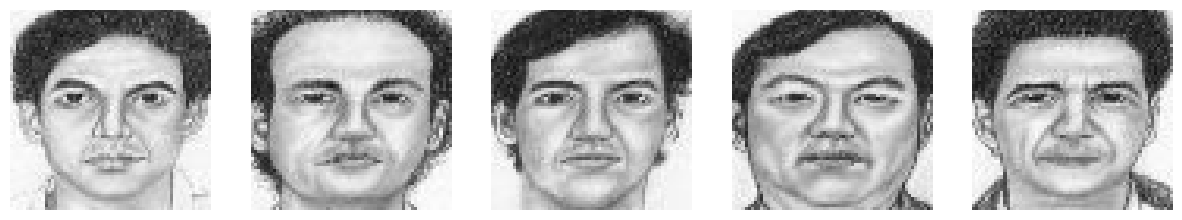

In [15]:
import matplotlib.pyplot as plt

# Function to visualize images from the dataset
def visualize_dataset(dataset, num_samples=5):
    plt.figure(figsize=(15, 6))
    for i, image_batch in enumerate(dataset.take(1)):
        for j in range(num_samples):
            plt.subplot(1, num_samples, j + 1)
            plt.imshow(image_batch[j].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

# Visualize samples from train_ds
visualize_dataset(train_ds)

# Visualize samples from val_ds
# visualize_dataset(val_ds)


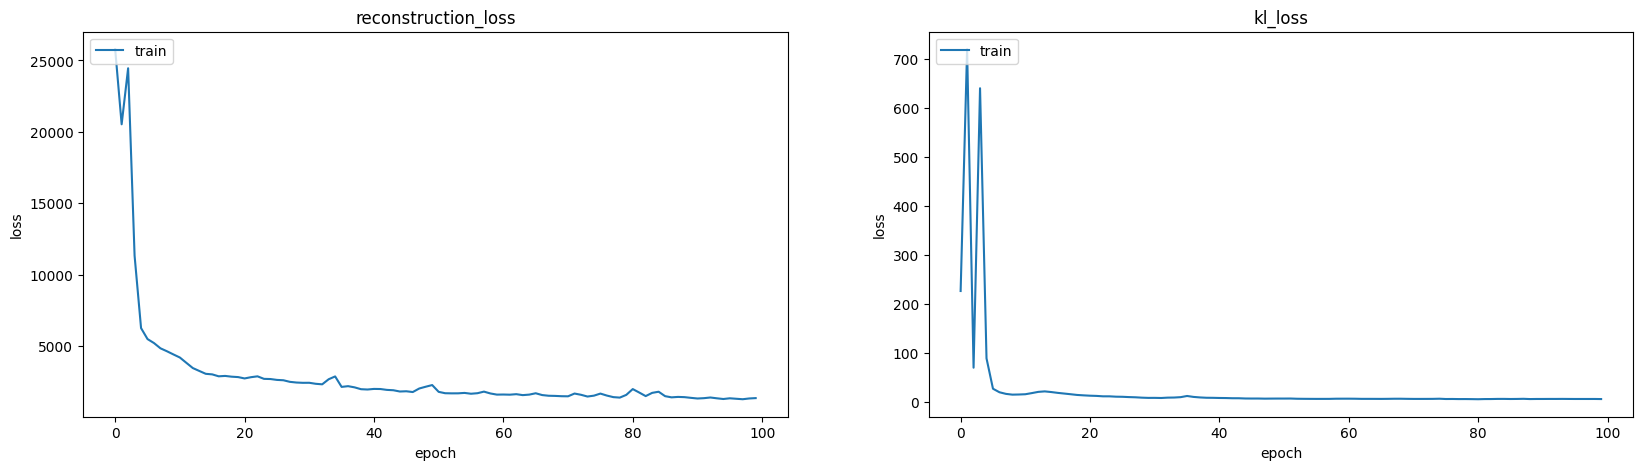

In [29]:
display_history(history_pvae)

In [23]:
test_ds_reconstructed_p = pvae.predict(train_ds)
test_ds_reconstructed_p = test_ds_reconstructed_p['reconstruction']

10/10 [==============================] - 3s 47ms/step


In [33]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Convert the Dataset of tensors to a numpy array for compatibility with skimage functions
original_images = np.concatenate([image.numpy() for image in train_ds], axis=0)

# Calculate SSIM and PSNR for the reconstructed images
avg_ssim = 0
avg_psnr = 0
num_samples = 0
for original, reconstructed in zip(original_images, test_ds_reconstructed_p):
    avg_ssim += ssim(original, reconstructed, data_range=1.0, multichannel=True)
    avg_psnr += psnr(original, reconstructed, data_range=1.0)
    num_samples += 1

avg_ssim /= num_samples
avg_psnr /= num_samples

print("Average SSIM:", avg_ssim)
print("Average PSNR:", avg_psnr)


<ipython-input-33-f7c5ec16e122>:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  avg_ssim += ssim(original, reconstructed, data_range=1.0, multichannel=True)


Average SSIM: 0.31284259725518065
Average PSNR: -35.955432748197566


In [25]:
def display_rec_images(test_ds_reconstructed):

    images = ['00001.jpg','00002.jpg','00003.jpg','00004.jpg','00005.jpg']

    fig=plt.figure(figsize=(20,5))

    for i in range(0,5):

        #display original image
        f = img_path + '/cropped_sketch/' + images[i]
        img = PIL.Image.open(f)

        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

        #display reconstructed image
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(test_ds_reconstructed[i].astype("uint8"))
        plt.axis('off')

    plt.show()

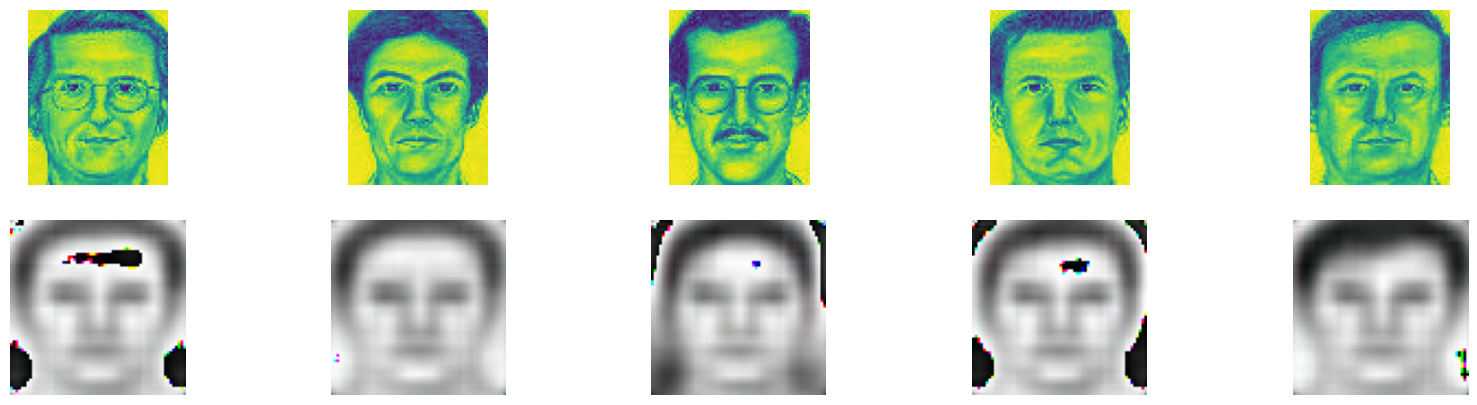

In [26]:
display_rec_images(test_ds_reconstructed_p)

Hyperparameter tuning

In [35]:
import itertools

# Define ranges for hyperparameters
alpha_values = [1.0, 1.5, 2.0]
beta_values = [5, 10, 15]
learning_rates = [0.001, 0.002, 0.003]

best_avg_ssim = -1  # Initialize with a low value
best_avg_psnr = -1  # Initialize with a low value
best_hyperparameters = {}

# Iterate over all combinations of hyperparameters
for alpha in alpha_values:
    for beta in beta_values:
        for lr in learning_rates:
            print(f"Running with hyperparameters: alpha={alpha}, beta={beta}, learning_rate={lr}")
            # Create and compile the model with the current hyperparameters
            ppreprocesser = create_preprocesser()
            pencoder = create_encoder()
            pdecoder = create_decoder()
            pvae = PVAE(ppreprocesser, pencoder, pdecoder, alpha, beta)
            pvae.compile(optimizer=keras.optimizers.Adam(lr))

            # Train the model
            history_pvae = pvae.fit(train_ds, epochs=50, batch_size=batch_size, verbose=0)

            # Evaluate the model on the validation dataset
            avg_ssim, avg_psnr = evaluate_model(pvae, val_ds)

            # Check if the current model is better than the previous best model
            if avg_ssim > best_avg_ssim:
                best_avg_ssim = avg_ssim
                best_avg_psnr = avg_psnr
                best_hyperparameters = {'alpha': alpha, 'beta': beta, 'learning_rate': lr}

print("Best SSIM:", best_avg_ssim)
print("Best PSNR:", best_avg_psnr)
print("Best Hyperparameters:", best_hyperparameters)


Running with hyperparameters: alpha=1.0, beta=5, learning_rate=0.001


KeyboardInterrupt: 